In [30]:
import cv2
print(cv2.__version__)
import numpy as np
import matplotlib.pyplot as plt
import random

3.4.2


In [33]:
def compute_homography(src, dst):
    A = np.zeros([2*src.shape[0], 9])
    for i in range(src.shape[0]):
        x=src[i,0]
        y=src[i,1]
        u=dst[i,0]
        v=dst[i,1]
        A[2*i,:]=[x,y,1,0,0,0,-u*x,-u*y,-u]
        A[2*i+1,:]=[0,0,0,x,y,1,-v*x,-v*y,-v]
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H

def apply_homography(src, H):
    dst = np.zeros(src.shape)
    for i in range(src.shape[0]):
        d3=np.dot(H,np.asarray([src[i,0],src[i,1],1]))
        dst[i,0]=d3[0]/float(d3[2])
        dst[i,1]=d3[1]/float(d3[2])
    return dst

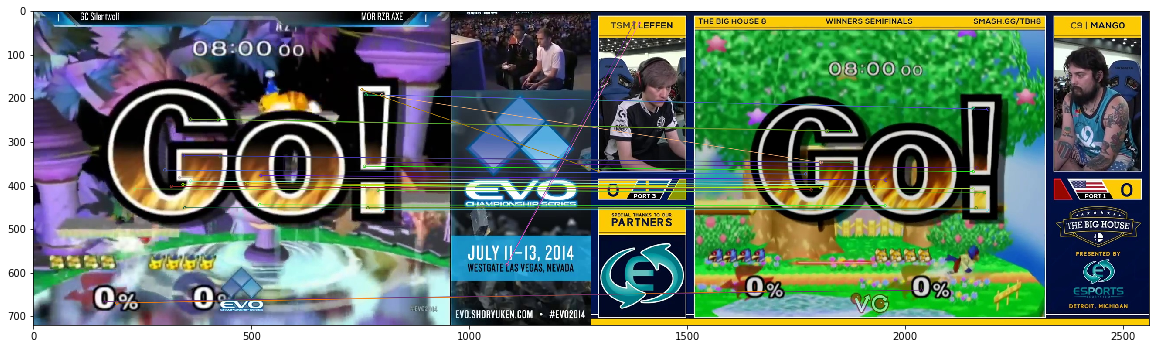

In [145]:
def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((20,2))
    pts2 = np.zeros((20,2))
    for i in range(20):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:40], kp1, kp2

def test_matches():
#     img1 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/EVO/Evo_2014_One_minute_kill/Evo_2014_One_minute_kill_140.jpg')#[220:400, 200:740,:]
#     img2 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/TBH/TBH8 SSBM - TSM _ Leffen (Fox) Vs/TBH8 SSBM - TSM _ Leffen (Fox) Vs_7.jpg')
    img1 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/EVO/Evo_2014_One_minute_kill/Evo_2014_One_minute_kill_201.jpg')#[220:400, 200:740,:]
    img2 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/TBH/TBH8 SSBM - TSM _ Leffen (Fox) Vs/TBH8 SSBM - TSM _ Leffen (Fox) Vs_16.jpg')
     
    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
    fig=plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

    
test_matches()

In [146]:
def RANSAC(Xs, Xd, max_iter, eps):
    '''Finds correspondences between two sets of points using the RANSAC algorithm.
    
    Input:
        Xs: the first set of points (source), shape [n, 2]
        Xd: the second set of points (destination) matched to the first set, shape [n, 2]
        max_iter: max iteration number of RANSAC
        eps: tolerance of RANSAC
    Output:
        inliers_id: the indices of matched pairs when using the homography given by RANSAC
        H: the homography, shape [3, 3]
    
    TODO: Implement the RANSAC function. 
    '''
    inliers_best = 0
    n = Xs.shape[0]
    H_best = np.zeros([3,3])
    for i in range(max_iter):
        src_sample = np.zeros([4,2])
        dst_sample = np.zeros([4,2])
        for j in range(4):
            ind = random.randint(0,n-1)
            src_sample[j,:]=Xs[ind,:]
            dst_sample[j,:]=Xd[ind,:]
        H = compute_homography(src_sample, dst_sample)
        dst_computed = apply_homography(Xs,H)
        inliers = (np.sqrt(np.sum((dst_computed-Xd)**2,axis=1))<eps).sum()
        if inliers > inliers_best:
            inliers_best = inliers
            H_best = np.copy(H)
    inliers_id = []
    dst_best = apply_homography(Xs,H_best)
    ed = np.sqrt(np.sum((dst_computed-Xd)**2,axis=1))
    for i in range(ed.shape[0]):
        if ed[i]<eps:
            inliers_id.append(i)
    return inliers_id, H_best

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


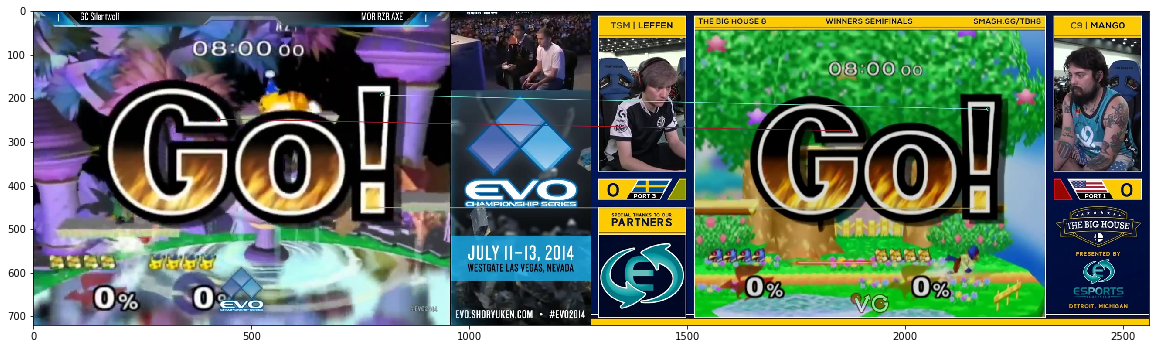

In [168]:
def test_ransac():
#     img1 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/EVO/Evo_2014_One_minute_kill/Evo_2014_One_minute_kill_140.jpg')#[220:400, 200:740,:3]
#     img2 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/TBH/TBH8 SSBM - TSM _ Leffen (Fox) Vs/TBH8 SSBM - TSM _ Leffen (Fox) Vs_7.jpg')
    img1 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/EVO/Evo_2014_One_minute_kill/Evo_2014_One_minute_kill_201.jpg')
    img2 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/TBH/TBH8 SSBM - TSM _ Leffen (Fox) Vs/TBH8 SSBM - TSM _ Leffen (Fox) Vs_16.jpg')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 1000, 2)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2)
    fig=plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
    return H
    
H = test_ransac()

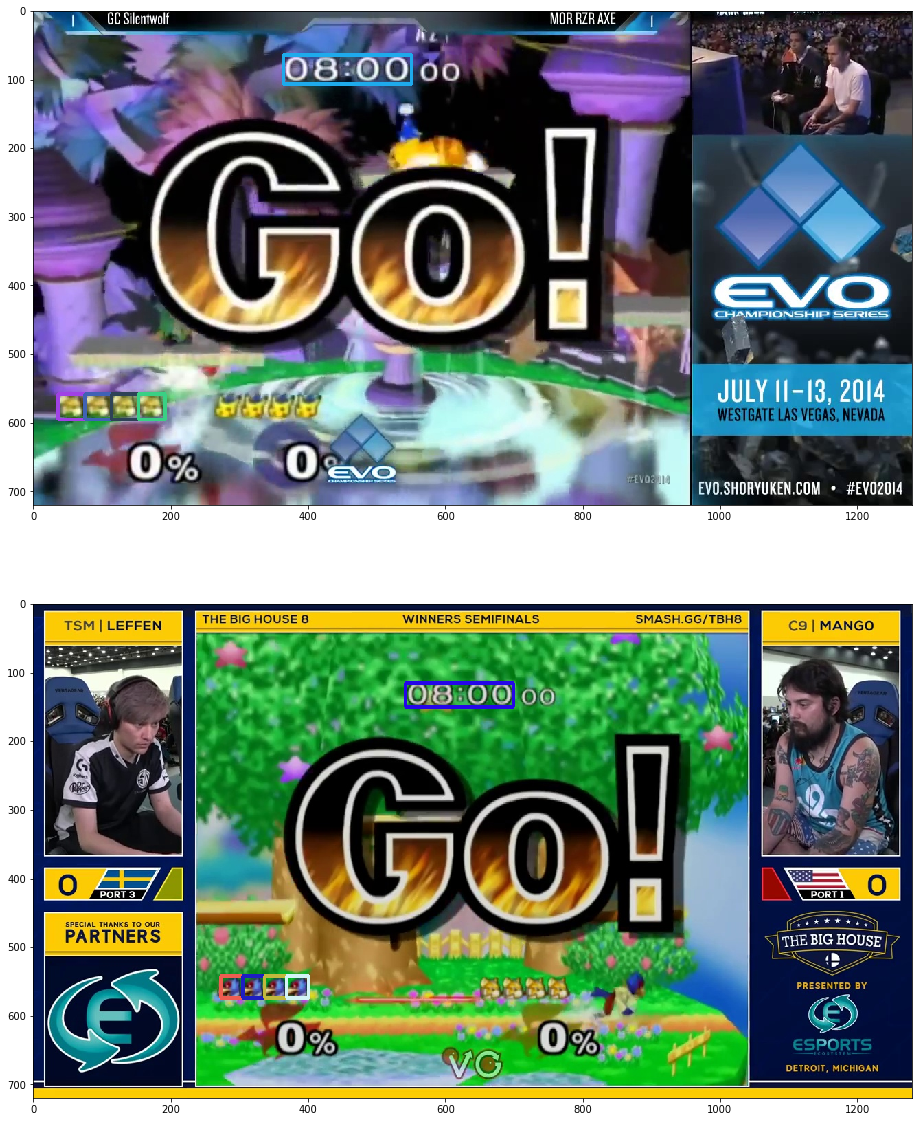

In [169]:
def compute_src_rois(rois, H):
    roissrc = []
    for roi in rois:
        y1,x1,y2,x2 = roi
        x1_, y1_ = apply_homography(np.array([[x1,y1]]), H)[0]
        x2_, y2_ = apply_homography(np.array([[x2,y2]]), H)[0]
        roissrc.append([int(y1_), int(x1_), int(y2_), int(x2_)])
    return roissrc
        
def draw_rois(img, rois):
    for roi in rois:
        y1,x1,y2,x2 = roi
        cv2.rectangle(img, (x1, y1), (x2, y2), thickness=3,
                    color=(random.randint(0, 255), random.randint(0, 255),random.randint(0, 255)))
       
        
rois = [[ 558, 36, 595, 75],
        [ 558, 75, 595, 114],
        [ 558, 114, 595, 153],
        [ 558, 153, 595, 192],
        [65, 364, 107, 551]]
roissrc = compute_src_rois(rois, H)
img1 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/EVO/Evo_2014_One_minute_kill/Evo_2014_One_minute_kill_201.jpg')
img2 = cv2.imread('/Users/Xipeng/Desktop/Smash_Bros_Master/data/TBH/TBH8 SSBM - TSM _ Leffen (Fox) Vs/TBH8 SSBM - TSM _ Leffen (Fox) Vs_16.jpg')
draw_rois(img1, rois)
draw_rois(img2, roissrc)
fig=plt.figure(figsize=(20, 20))
ax = plt.subplot(2,1,1)
plt.imshow(img1[:,:,::-1])
ax = plt.subplot(2,1,2)
plt.imshow(img2[:,:,::-1])

